In [3]:
import pandas as pd
import sklearn.metrics as metrique
from pandas import Series
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import numpy as np
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras import Model
from keras.layers import BatchNormalization
from keras import backend as K, regularizers, optimizers
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Load data
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv', na_filter=True)
col_del = ['Time' ,'V5', 'V6', 'V7', 'V8', 'V9','V13','V15', 'V16',  'V18', 'V19', 'V20','V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
tr_data = data.drop(col_del,axis =1)

X = tr_data.drop(['Class'], axis = 'columns')
Label_Data = tr_data['Class']

In [5]:
# Checking class distribution
from collections import Counter
counter = Counter(tr_data['Class'])
print("Original Class distribution:", counter)

Original Class distribution: Counter({0: 284315, 1: 492})


In [6]:
# Oversampling with SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_r, y = oversample.fit_resample(X, tr_data['Class'])
counter = Counter(y)
print("SMOTE Class distribution:", counter)

SMOTE Class distribution: Counter({0: 284315, 1: 284315})


In [7]:
# Scale data using StandardScaler
X_std = StandardScaler().fit_transform(X_r)

X_train,X_test,y_train,y_test = train_test_split(X_std, y, test_size=0.3, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (398041, 9)
X_test shape: (170589, 9)


In [8]:
# Reshape for LSTM
train_LSTM_X=X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
val_LSTM_X=X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
train_LSTM_y=y_train
val_LSTM_y=y_test

In [9]:
# Function to evaluate model and print metrics
def evaluate_model(model, X_val, y_val, title="Model"):
    yhat_probs = model.predict(X_val, verbose=0)[:,0]
    yhat_classes = [1 if prob > 0.5 else 0 for prob in yhat_probs]

    accuracy = accuracy_score(y_val, yhat_classes)
    precision = precision_score(y_val, yhat_classes)
    recall = recall_score(y_val, yhat_classes)
    f1 = f1_score(y_val, yhat_classes)
    cm = confusion_matrix(y_val, yhat_classes)

    print(f'{title} - Accuracy: {accuracy:.6f}')
    print(f'{title} - Precision: {precision:.6f}')
    print(f'{title} - Recall: {recall:.6f}')
    print(f'{title} - F1-score: {f1:.6f}')
    print('Confusion Matrix:\n', cm)
    return accuracy, precision, recall, f1


In [10]:
# Plot confusion matrix function
%matplotlib inline
import itertools
import matplotlib.pyplot as plt
labels = ['Normal','Fraud']

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_display = cm_normalized
    else:
        cm_display = cm

    thresh = cm_display.max() / 2.
    for i, j in itertools.product(range(cm_display.shape[0]), range(cm_display.shape[1])):
        if normalize:
            plt.text(j, i, f"{cm_display[i,j]:.2f}",
                     horizontalalignment="center",
                     color="white" if cm_display[i,j] > thresh else "black")
        else:
            plt.text(j, i, f"{cm_display[i,j]}",
                     horizontalalignment="center",
                     color="white" if cm_display[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [11]:
# Baseline Model with Adam optimizer and BN layers
inputs = Input((1, 9))
x = LSTM(50, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(inputs)
x = BatchNormalization()(x)
x = LSTM(50, dropout=0.3, recurrent_dropout=0.2)(x)
x = BatchNormalization()(x)
outputs = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.005))(x)
model = Model(inputs, outputs)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(train_LSTM_X, train_LSTM_y,epochs=60,batch_size=20000, validation_data=(val_LSTM_X, val_LSTM_y))


Epoch 1/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7674 - loss: 0.4958 - val_accuracy: 0.5009 - val_loss: 0.6718
Epoch 2/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9127 - loss: 0.2555 - val_accuracy: 0.5009 - val_loss: 0.6751
Epoch 3/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9157 - loss: 0.2427 - val_accuracy: 0.5009 - val_loss: 0.6786
Epoch 4/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9181 - loss: 0.2327 - val_accuracy: 0.5009 - val_loss: 0.6800
Epoch 5/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9191 - loss: 0.2267 - val_accuracy: 0.5009 - val_loss: 0.6760
Epoch 6/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9204 - loss: 0.2220 - val_accuracy: 0.5009 - val_loss: 0.6681
Epoch 7/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9225 - loss: 0.2156 - val_accuracy: 0.5009 - val_loss: 0.6538
Epoch 8/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9232 - loss: 0.2150 - val_accuracy: 0.5009 - v

In [12]:
# Evaluate baseline model
baseline_acc, baseline_prec, baseline_rec, baseline_f1 = evaluate_model(model, val_LSTM_X, val_LSTM_y, title="Baseline")

Baseline - Accuracy: 0.943384
Baseline - Precision: 0.961770
Baseline - Recall: 0.923677
Baseline - F1-score: 0.942339
Confusion Matrix:
 [[82012  3137]
 [ 6521 78919]]


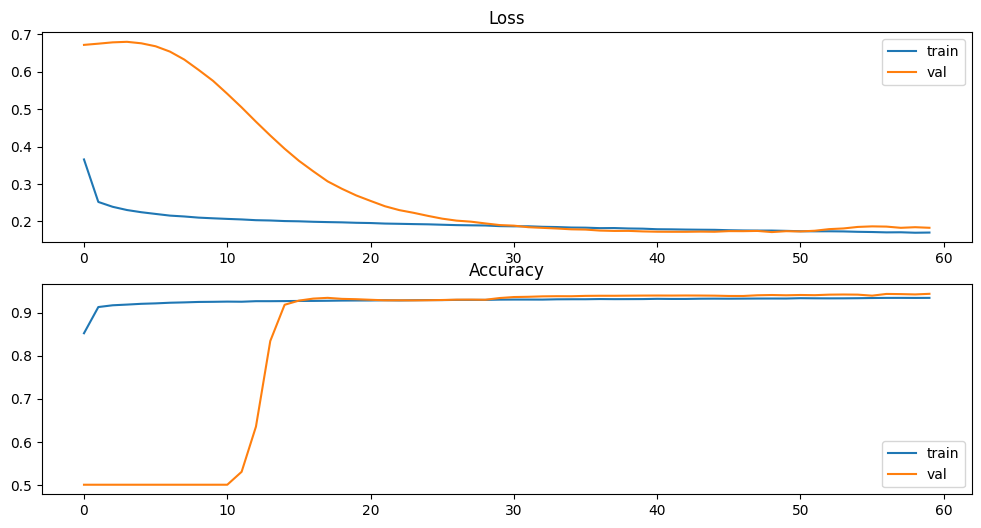

In [13]:
# Plot results for baseline
pyplot.figure(figsize=(12,6))
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()

pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()



In [14]:
# Attention Layer Implementation
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])



In [15]:
# Model with Attention + BN
inputs1=Input((1,9))
att_in=LSTM(50,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(inputs1)
att_in=BatchNormalization()(att_in)
att_in_1=LSTM(50,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(att_in)
att_in_1=BatchNormalization()(att_in_1)
att_out=attention()(att_in_1)
outputs1=Dense(1,activation='sigmoid',kernel_regularizer=regularizers.l2(0.005))(att_out)
model1=Model(inputs1,outputs1)

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history1=model1.fit(train_LSTM_X, train_LSTM_y,epochs=60,batch_size=30000, validation_data=(val_LSTM_X, val_LSTM_y))


Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.7789 - loss: 0.4882 - val_accuracy: 0.5009 - val_loss: 0.6729
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9117 - loss: 0.2591 - val_accuracy: 0.5009 - val_loss: 0.6681
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9147 - loss: 0.2453 - val_accuracy: 0.5009 - val_loss: 0.6711
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9174 - loss: 0.2377 - val_accuracy: 0.5009 - val_loss: 0.6755
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9194 - loss: 0.2299 - val_accuracy: 0.5009 - val_loss: 0.6785
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9198 - loss: 0.2264 - val_accuracy: 0.5009 - val_loss: 0.6780
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9209 - loss: 0.2230 - val_accuracy: 0.5009 - val_loss: 0.6765
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9219 - loss: 0.2192 - val_accuracy: 0.5009 - v

Baseline - Accuracy: 0.943384
Baseline - Precision: 0.961770
Baseline - Recall: 0.923677
Baseline - F1-score: 0.942339
Confusion Matrix:
 [[82012  3137]
 [ 6521 78919]]


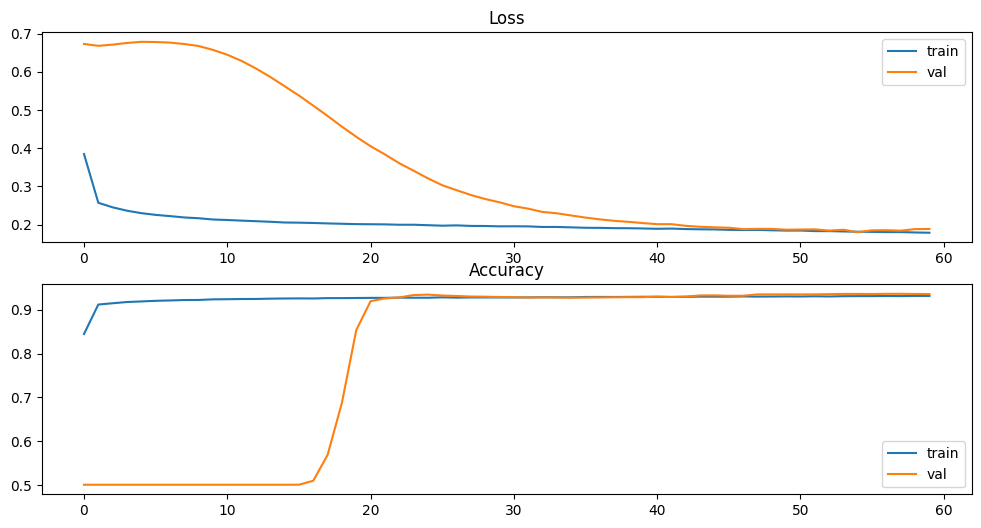

In [16]:
# Evaluate attention model
baseline_acc, baseline_prec, baseline_rec, baseline_f1 = evaluate_model(model, val_LSTM_X, val_LSTM_y, title="Baseline")

# Plot results for attention model
pyplot.figure(figsize=(12,6))
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history1.history['loss'], label='train')
pyplot.plot(history1.history['val_loss'], label='val')
pyplot.legend()

pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history1.history['accuracy'], label='train')
pyplot.plot(history1.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()



Epoch 1/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8081 - loss: 0.4321 - val_accuracy: 0.5009 - val_loss: 0.6829
Epoch 2/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9125 - loss: 0.2527 - val_accuracy: 0.5009 - val_loss: 0.6883
Epoch 3/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9188 - loss: 0.2321 - val_accuracy: 0.5009 - val_loss: 0.6961
Epoch 4/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9223 - loss: 0.2201 - val_accuracy: 0.5009 - val_loss: 0.6965
Epoch 5/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9235 - loss: 0.2147 - val_accuracy: 0.5009 - val_loss: 0.6917
Epoch 6/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9242 - loss: 0.2117 - val_accuracy: 0.5009 - val_loss: 0.6740
Epoch 7/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9256 - loss: 0.2058 - val_accuracy: 0.5009 - val_loss: 0.6512
Epoch 8/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9264 - loss: 0.2027 - val_accuracy: 0.5009 - v

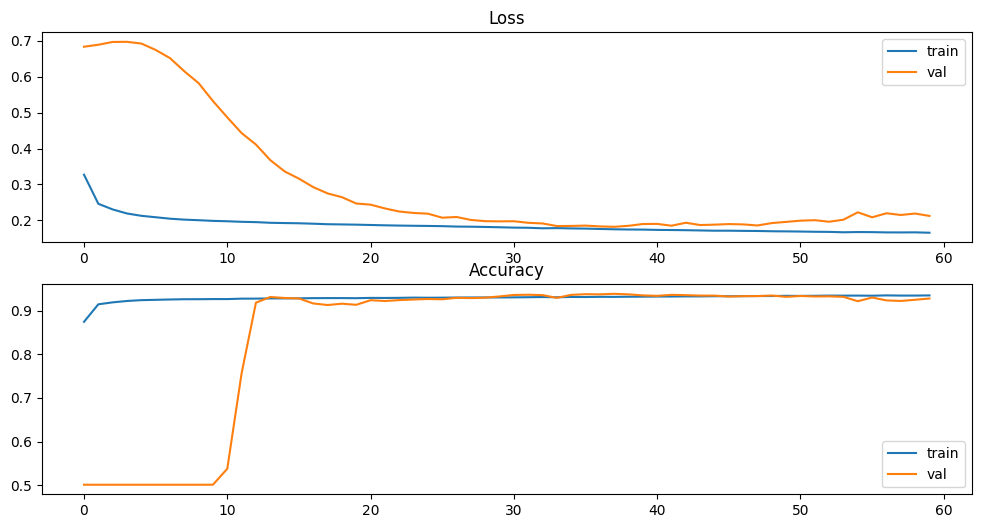

In [17]:
# EXPERIMENT 1: RMSprop Optimizer with Attention + BN
inputs_rms = Input((1, 9))
x_rms = LSTM(50, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(inputs_rms)
x_rms = BatchNormalization()(x_rms)
x_rms = LSTM(50, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(x_rms)
x_rms = BatchNormalization()(x_rms)
x_rms = attention()(x_rms)
outputs_rms = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.005))(x_rms)
model_rms = Model(inputs_rms, outputs_rms)

model_rms.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history_rms=model_rms.fit(train_LSTM_X, train_LSTM_y,epochs=60,batch_size=20000, validation_data=(val_LSTM_X, val_LSTM_y))
evaluate_model(model_rms, val_LSTM_X, val_LSTM_y, title="RMSprop Model")

# Plot results for RMSProp + Attention model
pyplot.figure(figsize=(12,6))
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history_rms.history['loss'], label='train')
pyplot.plot(history_rms.history['val_loss'], label='val')
pyplot.legend()

pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history_rms.history['accuracy'], label='train')
pyplot.plot(history_rms.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()

Epoch 1/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.7852 - loss: 0.4757 - val_accuracy: 0.9182 - val_loss: 0.6788
Epoch 2/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8996 - loss: 0.3067 - val_accuracy: 0.9244 - val_loss: 0.6699
Epoch 3/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9061 - loss: 0.2833 - val_accuracy: 0.8481 - val_loss: 0.6611
Epoch 4/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9095 - loss: 0.2734 - val_accuracy: 0.7297 - val_loss: 0.6514
Epoch 5/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9114 - loss: 0.2693 - val_accuracy: 0.6881 - val_loss: 0.6404
Epoch 6/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9124 - loss: 0.2629 - val_accuracy: 0.6994 - val_loss: 0.6276
Epoch 7/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9120 - loss: 0.2629 - val_accuracy: 0.7362 - val_loss: 0.6130
Epoch 8/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9133 - loss: 0.2598 - val_accuracy: 0.7975 - v

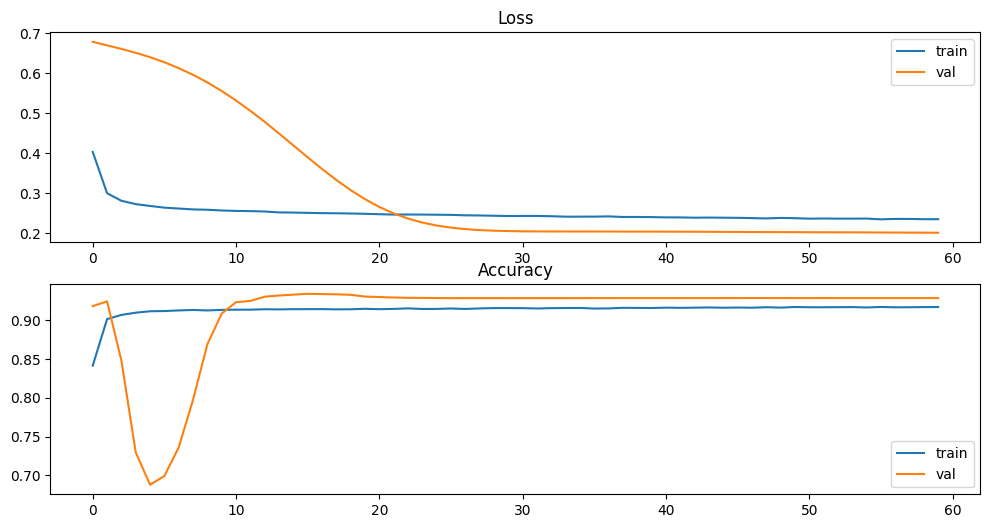

In [18]:
# EXPERIMENT 2: SGD Optimizer with Attention + BN
inputs_sgd = Input((1, 9))
x_sgd = LSTM(50, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(inputs_sgd)
x_sgd = BatchNormalization()(x_sgd)
x_sgd = LSTM(50, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(x_sgd)
x_sgd = BatchNormalization()(x_sgd)
x_sgd = attention()(x_sgd)
outputs_sgd = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.005))(x_sgd)
model_sgd = Model(inputs_sgd, outputs_sgd)
model_sgd.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
history_sgd=model_sgd.fit(train_LSTM_X, train_LSTM_y,epochs=60,batch_size=20000, validation_data=(val_LSTM_X, val_LSTM_y))
evaluate_model(model_sgd, val_LSTM_X, val_LSTM_y, title="SGD Model")

# Plot results for SGD + Attention model
pyplot.figure(figsize=(12,6))
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history_sgd.history['loss'], label='train')
pyplot.plot(history_sgd.history['val_loss'], label='val')
pyplot.legend()

pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history_sgd.history['accuracy'], label='train')
pyplot.plot(history_sgd.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()


Epoch 1/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8490 - loss: 0.3827 - val_accuracy: 0.5009 - val_loss: 0.6844
Epoch 2/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9223 - loss: 0.2256 - val_accuracy: 0.5009 - val_loss: 0.6884
Epoch 3/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9267 - loss: 0.2113 - val_accuracy: 0.5009 - val_loss: 0.6970
Epoch 4/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9273 - loss: 0.2054 - val_accuracy: 0.5009 - val_loss: 0.7028
Epoch 5/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9292 - loss: 0.1994 - val_accuracy: 0.5009 - val_loss: 0.7056
Epoch 6/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9292 - loss: 0.1971 - val_accuracy: 0.5009 - val_loss: 0.7064
Epoch 7/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9303 - loss: 0.1929 - val_accuracy: 0.5009 - val_loss: 0.7040
Epoch 8/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9300 - loss: 0.1921 - val_accuracy: 0.5009 - v

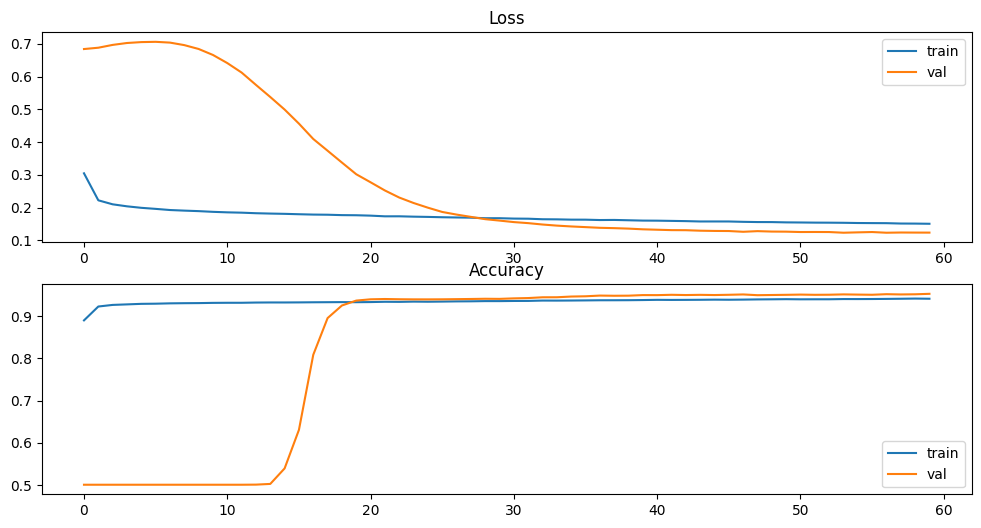

In [19]:
# EXPERIMENT 3: Using RobustScaler instead of StandardScaler with Attention
X_robust = RobustScaler().fit_transform(X_r)
X_train_r,X_test_r,y_train_r,y_test_r = train_test_split(X_robust, y, test_size=0.3, random_state=42)

train_LSTM_X_r=X_train_r.reshape((X_train_r.shape[0], 1, X_train_r.shape[1]))
val_LSTM_X_r=X_test_r.reshape((X_test_r.shape[0], 1, X_test_r.shape[1]))

inputs_r = Input((1,9))
x1_r = LSTM(50, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(inputs_r)
x1_r = BatchNormalization()(x1_r)
x2_r = LSTM(50, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(x1_r)
x2_r = BatchNormalization()(x2_r)
x2_r = attention()(x2_r)
outputs_r = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.005))(x2_r)
model_r = Model(inputs_r, outputs_r)
model_r.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_r=model_r.fit(train_LSTM_X_r, y_train_r, epochs=60,batch_size=20000, validation_data=(val_LSTM_X_r, y_test_r))
evaluate_model(model_r, val_LSTM_X_r, y_test_r, title="RobustScaler Model")

# Plot results for RobustScaler + Attention model
pyplot.figure(figsize=(12,6))
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history_r.history['loss'], label='train')
pyplot.plot(history_r.history['val_loss'], label='val')
pyplot.legend()

pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history_r.history['accuracy'], label='train')
pyplot.plot(history_r.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()

Epoch 1/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5897 - loss: 0.6874 - val_accuracy: 0.5013 - val_loss: 0.6891
Epoch 2/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7896 - loss: 0.4403 - val_accuracy: 0.5013 - val_loss: 0.6934
Epoch 3/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7986 - loss: 0.4198 - val_accuracy: 0.5013 - val_loss: 0.6950
Epoch 4/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8049 - loss: 0.4095 - val_accuracy: 0.5013 - val_loss: 0.6945
Epoch 5/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8093 - loss: 0.4027 - val_accuracy: 0.5013 - val_loss: 0.6913
Epoch 6/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8123 - loss: 0.3970 - val_accuracy: 0.5013 - val_loss: 0.6868
Epoch 7/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8152 - loss: 0.3919 - val_accuracy: 0.5013 - val_loss: 0.6807
Epoch 8/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8170 - loss: 0.3886 - val_accuracy: 0.5013 - v

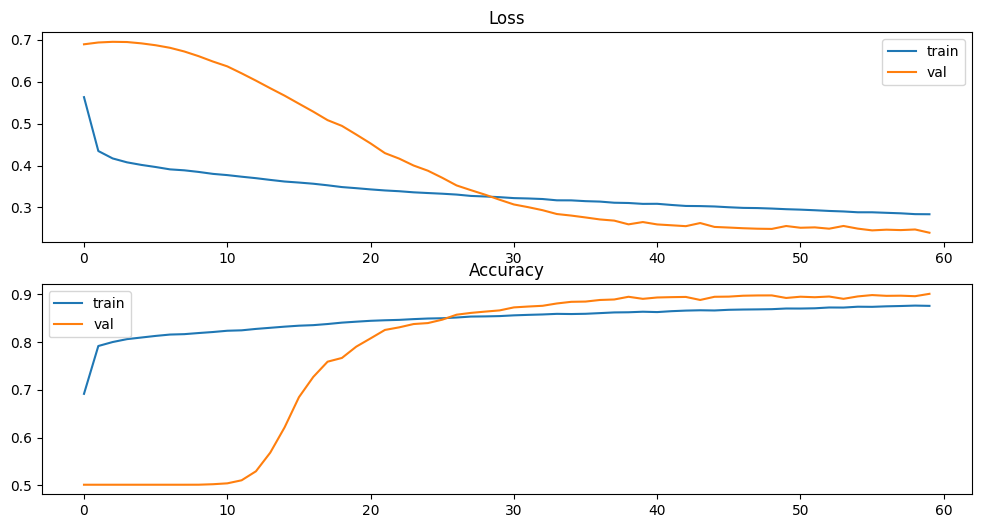

In [20]:
# EXPERIMENT 4: ADASYN with Attention
from imblearn.over_sampling import ADASYN
adasyn = ADASYN()
X_ad, y_ad = adasyn.fit_resample(X, tr_data['Class'])
X_ad_std = StandardScaler().fit_transform(X_ad)
X_train_ad,X_test_ad,y_train_ad,y_test_ad = train_test_split(X_ad_std, y_ad, test_size=0.3, random_state=42)
train_LSTM_X_ad=X_train_ad.reshape((X_train_ad.shape[0], 1, X_train_ad.shape[1]))
val_LSTM_X_ad=X_test_ad.reshape((X_test_ad.shape[0], 1, X_test_ad.shape[1]))

inputs_ad = Input((1, 9))
x_ad = LSTM(50, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(inputs_ad)
x_ad = BatchNormalization()(x_ad)
x_ad = LSTM(50, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(x_ad)
x_ad = BatchNormalization()(x_ad)
x_ad = attention()(x_ad)
outputs_ad = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.005))(x_ad)
model_ad = Model(inputs_ad, outputs_ad)
model_ad.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_ad=model_ad.fit(train_LSTM_X_ad, y_train_ad, epochs=60,batch_size=20000, validation_data=(val_LSTM_X_ad, y_test_ad))
evaluate_model(model_ad, val_LSTM_X_ad, y_test_ad, title="ADASYN Model")

# Plot results for ADASYN + Attention model
pyplot.figure(figsize=(12,6))
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history_ad.history['loss'], label='train')
pyplot.plot(history_ad.history['val_loss'], label='val')
pyplot.legend()

pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history_ad.history['accuracy'], label='train')
pyplot.plot(history_ad.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()

Epoch 1/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.7375 - loss: 0.5255 - val_accuracy: 0.5009 - val_loss: 0.6818
Epoch 2/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9129 - loss: 0.2643 - val_accuracy: 0.5009 - val_loss: 0.6837
Epoch 3/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9166 - loss: 0.2494 - val_accuracy: 0.5009 - val_loss: 0.6895
Epoch 4/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9167 - loss: 0.2431 - val_accuracy: 0.5009 - val_loss: 0.6906
Epoch 5/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9176 - loss: 0.2387 - val_accuracy: 0.5009 - val_loss: 0.6862
Epoch 6/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9189 - loss: 0.2342 - val_accuracy: 0.5009 - val_loss: 0.6787
Epoch 7/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9209 - loss: 0.2299 - val_accuracy: 0.5009 - val_loss: 0.6639
Epoch 8/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9207 - loss: 0.2272 - val_accuracy: 0.5009 - v

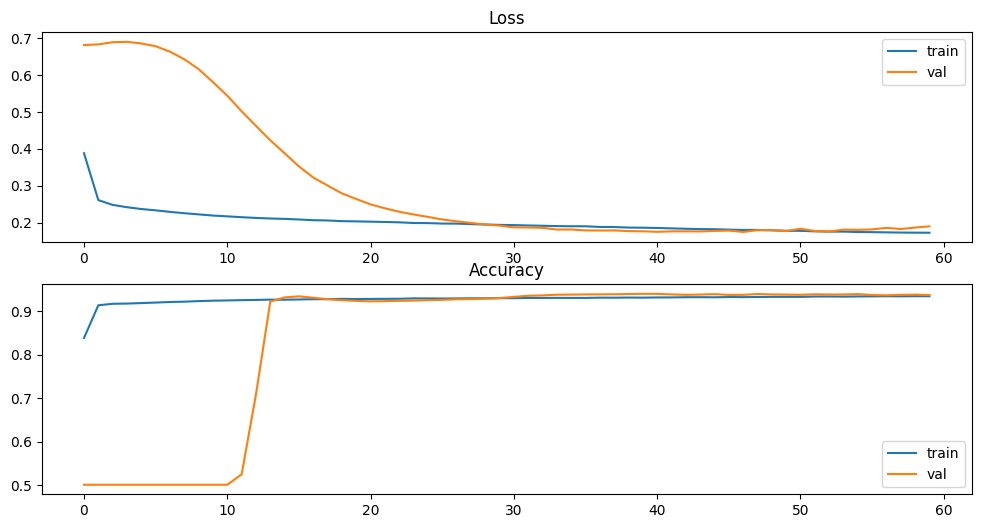

In [21]:
# Experiment 5: Robust optimization idea: Increase L2 penalty with Attention
inputs_robust = Input((1,9))
x1_robust = LSTM(50, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(inputs_robust)
x1_robust = BatchNormalization()(x1_robust)
x2_robust = LSTM(50, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(x1_robust)
x2_robust = BatchNormalization()(x2_robust)
x2_robust = attention()(x2_robust)
outputs_robust = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(x2_robust)
model_robust = Model(inputs_robust, outputs_robust)
model_robust.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_robust=model_robust.fit(train_LSTM_X, train_LSTM_y, epochs=60,batch_size=20000, validation_data=(val_LSTM_X, val_LSTM_y))
evaluate_model(model_robust, val_LSTM_X, val_LSTM_y, title="More Heavily Regularized Model")

# Plot results for ADASYN + Attention model
pyplot.figure(figsize=(12,6))
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history_robust.history['loss'], label='train')
pyplot.plot(history_robust.history['val_loss'], label='val')
pyplot.legend()

pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history_robust.history['accuracy'], label='train')
pyplot.plot(history_robust.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()